In [2]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
from shapely.geometry import Polygon, LineString, Point
import matplotlib.patches as patches
import shapefile
import shutil
from PIL import Image
import requests
from io import BytesIO
from urllib.parse import urlparse, parse_qs, urlunparse, urlencode
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import zipfile
import io
from tqdm import tqdm

In [3]:
# Abre el archivo GeoTIFF
dataset = rasterio.open('..\\data\\Zona\\of5mtif1678296896753.tif')

# Imprime información sobre el archivo
print(f'Número de bandas: {dataset.count}')
print(f'Tamaño del archivo: {dataset.width}x{dataset.height}')
print(f'Sistema de coordenadas: {dataset.crs}')

Número de bandas: 3
Tamaño del archivo: 13734x13638
Sistema de coordenadas: EPSG:25831


In [3]:
def image_to_window(coordenadas_image, coordenadas_window, transform, shape):
    xmin, ymin, xmax, ymax = coordenadas_image
    xmin_window, ymin_window = coordenadas_window
    len_y, len_x, len_z = shape

    # Ajusta las posiciones de los rectángulos a la ventana
    xmin, ymin, xmax, ymax = xmin - xmin_window, ymin - ymin_window, xmax - xmin_window, ymax - ymin_window
    
    # Escala las posiciones a la resolución de la imagen
    xmin, ymin, xmax, ymax = xmin / transform.a, ymin / transform.a, xmax / transform.a, ymax / transform.a

    # Invierte las coordenadas en el eje y
    ymin, ymax = len_y - ymax, len_y - ymin

    return int(xmin), int(ymin), int(xmax), int(ymax)

def window_to_image(coordenadas_image, coordenadas_window, transform, shape):
    xmin, ymin, xmax, ymax = coordenadas_image
    xmin_window, ymin_window = coordenadas_window
    len_y, len_x, len_z = shape

    # Invierte las coordenadas en el eje y
    ymin, ymax = len_y - ymax, len_y - ymin

    # Escala las posiciones a la resolución de la imagen
    xmin, ymin, xmax, ymax = xmin * transform.a, ymin * transform.a, xmax * transform.a, ymax * transform.a

    # Ajusta las posiciones de los rectángulos a la ventana
    xmin, ymin, xmax, ymax = xmin - xmin_window, ymin - ymin_window, xmax - xmin_window, ymax - ymin_window
    
    return int(xmin), int(ymin), int(xmax), int(ymax)

def xyxy_to_cxcywh(coordenadas):
    xmin, ymin, xmax, ymax = coordenadas
    x = (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    w = xmax - xmin
    h = ymax - ymin
    return int(x), int(y), int(w), int(h)

def cxcywh_to_xyxy(coordenadas):
    x, y, w, h = coordenadas
    xmin = x - w / 2
    ymin = y - h / 2
    xmax = x + w / 2
    ymax = y + h / 2
    return int(xmin), int(ymin), int(xmax), int(ymax)

# Funcion que pasa xmin, ymin, xmax, ymax a x, y, w, h siendo x, y la esquina superior izquierda
def xyxy_to_xywh(coordenadas):
    xmin, ymin, xmax, ymax = coordenadas
    x = xmin
    y = ymin
    w = xmax - xmin
    h = ymax - ymin
    return int(x), int(y), int(w), int(h)

# Funcion que pasa x, y, w, h a xmin, ymin, xmax, ymax siendo x, y la esquina superior izquierda
def xywh_to_xyxy(coordenadas):
    x, y, w, h = coordenadas
    xmin = x
    ymin = y
    xmax = x + w
    ymax = y + h
    return int(xmin), int(ymin), int(xmax), int(ymax)

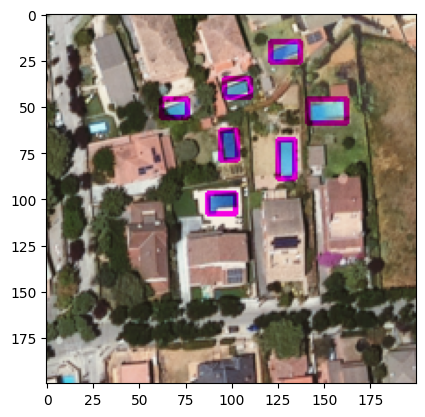

In [4]:
# Lee el archivo shapefile
regions = gpd.read_file('..\\data\\Zona\\clean\\bt5mv20sh0f286122hp1r060.shp')

xmin_window, ymin_window, xmax_window, ymax_window = 420660, 4590892, 420660+100, 4590892+100

# Recorta el GeoTIFF según las coordenadas de la window
window = rasterio.windows.from_bounds(xmin_window, ymin_window, xmax_window, ymax_window, dataset.transform)
clipped_data = dataset.read(window=window)
clipped_data = np.moveaxis(clipped_data, 0, -1)

area = Polygon([(xmin_window, ymin_window), (xmax_window, ymin_window), (xmax_window, ymax_window), (xmin_window, ymax_window)])

for region in regions[regions.geometry.covered_by(area)].geometry:
    
    xmin, ymin, xmax, ymax = region.bounds

    xmin, ymin, xmax, ymax = image_to_window((xmin, ymin, xmax, ymax), (xmin_window, ymin_window), dataset.transform, clipped_data.shape)

    # Dibuja los rectángulos
    cv2.rectangle(clipped_data[:, :, 1], (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)

# Visualiza la ventana con los rectángulos
plt.imshow(clipped_data)
plt.show()

In [17]:
# Lee el archivo shapefile
regions = gpd.read_file('..\\data\\Zona\\clean\\bt5mv20sh0f286122hp1r060.shp')

xmin_window, ymin_window, xmax_window, ymax_window = 420660, 4590892, 420660+100, 4590892+100

# Recorta el GeoTIFF según las coordenadas de la window
window = rasterio.windows.from_bounds(xmin_window, ymin_window, xmax_window, ymax_window, dataset.transform)
clipped_data = dataset.read(window=window)
clipped_data = np.moveaxis(clipped_data, 0, -1)

area = Polygon([(xmin_window, ymin_window), (xmax_window, ymin_window), (xmax_window, ymax_window), (xmin_window, ymax_window)])

fig, ax = plt.subplots()

for region in regions[regions.geometry.covered_by(area)].geometry:
    
    xmin, ymin, xmax, ymax = region.bounds

    xmin, ymin, xmax, ymax = image_to_window((xmin, ymin, xmax, ymax), (xmin_window, ymin_window), dataset.transform, clipped_data.shape)

    x, y, w, h = xyxy_to_xywh((xmin, ymin, xmax, ymax))

    # Dibuja los rectángulos
    bb = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(bb)

# Visualiza la ventana con los rectángulos
ax.imshow(clipped_data)
plt.show()

In [30]:
list_regions = []
for file in os.listdir("..\data\Zona\clean"):
    if file.endswith(".shp"):
        regions = gpd.read_file(f'..\\data\\Zona\\clean\\{file}')
        list_regions.append(regions)

# find global xmin, ymin, xmax, ymax
xmin_total, ymin_total, xmax_total, ymax_total = 10**10, 10**10, 0, 0
for regions in list_regions:
    for region in regions.geometry:
        xmin, ymin, xmax, ymax = region.bounds
        xmin_total = min(xmin_total, xmin)
        ymin_total = min(ymin_total, ymin)
        xmax_total = max(xmax_total, xmax)
        ymax_total = max(ymax_total, ymax)
        
xmin_total, ymin_total, xmax_total, ymax_total = int(xmin_total), int(ymin_total), int(xmax_total), int(ymax_total)

print(xmin_total, ymin_total, xmax_total, ymax_total)
print(xmax_total - xmin_total, ymax_total - ymin_total)

418251.89 4590058.18 425216.75 4596979.79


AttributeError: 'GeoDataFrame' object has no attribute 'bbox'

In [18]:
# Create folder for images
path_folder = "..\\data\\Zona\\dataset_700x700\\"
path_images = f"{path_folder}images\\"
path_annotations = f"{path_folder}"

if not os.path.exists(path_folder):
    os.makedirs(path_folder)

if not os.path.exists(path_images):
    os.makedirs(path_images)

if not os.path.exists(path_annotations):
    os.makedirs(path_annotations)

n_image = 0 # id de la imagen
n_total = 0 # id total de la anotación

num_max_pools_per_image = 0

inici = 200

N = 350
step = 200
final_data = {"images": [], "annotations": [], "categories": []}

# Crea las categorías
cat = []
cat.append({"id" : 0, "name" : "piscina", "supercategory": "N/A"})
final_data["categories"] = cat

# Crea las imágenes y las anotaciones
annotations = []
image_list = []
for step_x in range(inici, xmax_total - xmin_total, step):
    for step_y in range(inici, ymax_total - ymin_total, step):
        n_id = 0 # id de la anotación en la imagen

        xmin_window = xmin_total + step_x - N
        ymin_window = ymin_total + step_y - N
        xmax_window = xmin_total + step_x
        ymax_window = ymin_total + step_y


        # Recorta el GeoTIFF según las coordenadas de la window
        window = rasterio.windows.from_bounds(xmin_window, ymin_window, xmax_window, ymax_window, dataset.transform)
        clipped_data = dataset.read(window=window)
        clipped_data = np.moveaxis(clipped_data, 0, -1)

        area = Polygon([(xmin_window, ymin_window), (xmax_window, ymin_window), (xmax_window, ymax_window), (xmin_window, ymax_window)])

        annotations_image = []

        # Muestra todas las regiones de interés en la window
        for regions in list_regions:
            for region in regions[regions.geometry.covered_by(area)].geometry:
                annotation = {
                                "id" : n_total,
                                "image_id" : n_image,
                                "category_id" : 0,
                                "area" : region.area,
                                "bbox" : xyxy_to_xywh(image_to_window((region.bounds), (xmin_window, ymin_window), dataset.transform, clipped_data.shape))
                            }
                

                annotations_image.append(annotation)
                n_id += 1
                n_total += 1

        for annotation in annotations_image:
            annotation["iscrowd"] = 1 if len(annotations_image) > 1 else 0
            annotations.append(annotation)

        if n_id != 0:
            # Guarda la imagen con nombre "n_image"_"numero de regiones en la imagen".jpg
            cv2.imwrite(f'{path_images}{n_image}_{n_id}.jpg', cv2.cvtColor(clipped_data, cv2.COLOR_RGB2BGR))

            image_list.append({"id" : n_image,
                               "file_name" : f'{n_image}_{n_id}.jpg',
                               "width" : N,
                               "height" : N,
                               "data_captured" : "http://www.icc.cat/appdownloads/?c=dlftopo5m",
                               "licence" : 1,
                               "coco_url" : "",
                               "flickr_url" : ""})
            n_image += 1

            if num_max_pools_per_image < n_id:
                num_max_pools_per_image = n_id
            
final_data["images"] = image_list
final_data["annotations"] = annotations

with open(f'{path_annotations}annotations.json', 'w') as f:
    json.dump(final_data, f)

print("num_max_pools_per_image", num_max_pools_per_image)

num_max_pools_per_image 90


In [20]:
clipped_data.shape

(700, 700, 3)

# Separar train y test

In [ ]:
with open(f'{path_annotations}annotations_{4}.json', 'r') as f:
    data = json.load(f)

# Change category_id from 0 to 1
for annotation in data["annotations"]:
    annotation["category_id"] = 1

data["categories"] = [{"id" : 1, "name" : "piscina", "supercategory": "N/A"}]

with open(f'{path_annotations}annotations_{4}.json', 'w') as f:
    json.dump(data, f)

In [17]:
data["images"][0]

{'id': 146,
 'file_name': '146_5.jpg',
 'width': 700,
 'height': 700,
 'data_captured': 'http://www.icc.cat/appdownloads/?c=dlftopo5m',
 'licence': 1,
 'coco_url': '',
 'flickr_url': ''}

In [23]:
for annotation in data["annotations"]:
    if annotation["image_id"] == 3050:
        print(annotation)

{'id': 4292, 'image_id': 3050, 'category_id': 1, 'area': 0.0, 'bbox': [13, 570, 16, 22], 'iscrowd': 1}
{'id': 4293, 'image_id': 3050, 'category_id': 1, 'area': 0.0, 'bbox': [132, 206, 23, 35], 'iscrowd': 1}
{'id': 4294, 'image_id': 3050, 'category_id': 1, 'area': 0.0, 'bbox': [179, 427, 30, 22], 'iscrowd': 1}
{'id': 4295, 'image_id': 3050, 'category_id': 1, 'area': 0.0, 'bbox': [299, 484, 15, 16], 'iscrowd': 1}
{'id': 4296, 'image_id': 3050, 'category_id': 1, 'area': 0.0, 'bbox': [595, 460, 26, 27], 'iscrowd': 1}


In [10]:
file = f'{path_annotations}annotations_4_recounted'

with open(f'{file}.json', 'r') as f:
    data = json.load(f)

# Divide el dataset en train, val y test
split_train = 0.8
split_val = 0.1
split_test = 0.1

# Hace train
ids_train = (0, int(len(data["images"])*split_train))
data_train = {}
data_train["images"] = data["images"][ids_train[0]:ids_train[1]]
data_train["annotations"] = [d for d in data["annotations"] if d["image_id"] in range(ids_train[0], ids_train[1])]
data_train["categories"] = data["categories"]

# Hace validation
ids_val = (ids_train[1], ids_train[1] + int(len(data["images"])*split_val))
data_val = {}
data_val["images"] = data["images"][ids_val[0]:ids_val[1]]
data_val["annotations"] = [d for d in data["annotations"] if d["image_id"] in range(ids_val[0], ids_val[1])]
data_val["categories"] = data["categories"]

# Hace test
ids_test = (ids_val[1], ids_val[1] + int(len(data["images"])*split_test))
data_test = {}
data_test["images"] = data["images"][ids_test[0]:ids_test[1]]
data_test["annotations"] = [d for d in data["annotations"] if d["image_id"] in range(ids_test[0], ids_test[1])]
data_test["categories"] = data["categories"]

# Guarda los archivos
with open(f'{file}_train.json', 'w') as f:
    json.dump(data_train, f)

with open(f'{file}_val.json', 'w') as f:
    json.dump(data_val, f)

with open(f'{file}_test.json', 'w') as f:
    json.dump(data_test, f)

# Mas datos

In [35]:
# parse url
url = "https://geoserveis.icgc.cat/servei/catalunya/orto-territorial/wms?REQUEST=GetMap&VERSION=1.3.0&SERVICE=WMS&CRS=EPSG:25831&BBOX=290368.84,4538236.42,292203.28,4540070.86&WIDTH=700&HEIGHT=700&LAYERS=ortofoto_color_serie_anual&STYLES=&FORMAT=PNG&BGCOLOR=0xFFFFFF&TRANSPARENT=TRUE&EXCEPTION=INIMAGE"
parsed_url = urlparse(url)
parsed_query = parse_qs(parsed_url.query)
parsed_query

{'REQUEST': ['GetMap'],
 'VERSION': ['1.3.0'],
 'SERVICE': ['WMS'],
 'CRS': ['EPSG:25831'],
 'BBOX': ['290368.84,4538236.42,292203.28,4540070.86'],
 'WIDTH': ['700'],
 'HEIGHT': ['700'],
 'LAYERS': ['ortofoto_color_serie_anual'],
 'FORMAT': ['PNG'],
 'BGCOLOR': ['0xFFFFFF'],
 'TRANSPARENT': ['TRUE'],
 'EXCEPTION': ['INIMAGE']}

In [57]:
# modify boundiong box
bbox = parsed_query["BBOX"][0].split(",")
bbox = [float(x) for x in bbox]
bbox[0] = bbox[2] - 100
bbox[1] = bbox[3] - 100
parsed_query["WIDTH"] = ["700"]
parsed_query["HEIGHT"] = ["700"]
# add styles
parsed_query["STYLES"] = [""]
parsed_query["BBOX"] = [",".join([str(x) for x in bbox])]

In [58]:
parsed_query

{'REQUEST': ['GetMap'],
 'VERSION': ['1.3.0'],
 'SERVICE': ['WMS'],
 'CRS': ['EPSG:25831'],
 'BBOX': ['292103.28,4539970.86,292203.28,4540070.86'],
 'WIDTH': ['700'],
 'HEIGHT': ['700'],
 'LAYERS': ['ortofoto_color_serie_anual'],
 'FORMAT': ['PNG'],
 'BGCOLOR': ['0xFFFFFF'],
 'TRANSPARENT': ['TRUE'],
 'EXCEPTION': ['INIMAGE'],
 'STYLES': ['']}

In [59]:
# unparse url
unparsed_url = urlunparse(parsed_url._replace(query=urlencode(parsed_query, doseq=True)))

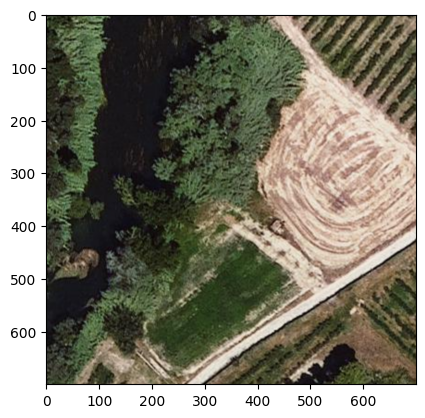

In [60]:
#  make request from url
response = requests.get(unparsed_url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.show()

In [48]:
np.array(img).shape

(4096, 4096, 4)

In [7]:
response = requests.get("https://descarregues.icgc.cat/generateZip/d90e37e6dbc9da6f8dd2bee35bba2f70/279110&/7/shp")
web  = BeautifulSoup(response.content)
url_zip = web.p.a["href"]
r = requests.get(url_zip, stream=True)
zipfile.ZipFile(BytesIO(r.content)).extractall(path=path)

In [34]:
for sector in Sectors["CODI_UNIT"]:
    sector = sector.replace("-", "")
    response = requests.get("https://descarregues.icgc.cat/generateZip/d90e37e6dbc9da6f8dd2bee35bba2f70/"+sector+"&/7/shp")
    url_zip  = BeautifulSoup(response.content).p.a["href"]
    r = requests.get(url_zip, stream=True)
    zipfile.ZipFile(BytesIO(r.content)).extractall(path=path)
    break

In [40]:
url = "https://geoserveis.icgc.cat/servei/catalunya/orto-territorial/wms?REQUEST=GetMap&VERSION=1.3.0&SERVICE=WMS&CRS=EPSG:25831&BBOX=290368.84,4538236.42,292203.28,4540070.86&WIDTH=4096&HEIGHT=4096&LAYERS=ortofoto_color_serie_anual&STYLES=&FORMAT=PNG&BGCOLOR=0xFFFFFF&TRANSPARENT=TRUE&EXCEPTION=INIMAGE"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.show()

In [61]:
url = "https://descarregues.icgc.cat/generateZip/3e670cf8ae8aa6776aa89b4e3836ddb2/279110&/13/jp2"
response = requests.get(url)
url_zip  = BeautifulSoup(response.content).p.a["href"]
r = requests.get(url_zip, stream=True)
zipfile.ZipFile(BytesIO(r.content)).extractall(path=path)

In [4]:
def extract_zips_in_zip(zip, path, ext = None):
    for f in zip.namelist():
        # read inner zip file into bytes buffer
        content = io.BytesIO(zip.read(f))
        zip_file = zipfile.ZipFile(content)
        for i in zip_file.namelist():
            if ext is None:
                zip_file.extract(i, path)
            elif i.endswith(ext):
                zip_file.extract(i, path)

def remove_files_in_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        remove_file(file_path)

def remove_file(file_path):
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [5]:
path_shp_raw = "..\\data\\Automatic\\No_format\\Annotations_raw\\"
path_shp = "..\\data\\Automatic\\No_format\\Annotations\\"
path_images_raw = "..\\data\\Automatic\\No_format\\Images_raw\\"

In [6]:
Sectors = gpd.read_file('..\\data\\topografia-5000-v2r0-metadades-20200827.shp')

In [46]:
# Download, filter and save annotations
for sector in tqdm(Sectors["CODI_UNIT"]):
    sector = sector.replace("-", "")
    url = "https://descarregues.icgc.cat/generateZip/d90e37e6dbc9da6f8dd2bee35bba2f70/"+sector+"&/7/shp"
    response = requests.get(url)
    url_zip  = BeautifulSoup(response.content).p.a["href"]
    r = requests.get(url_zip, stream=True)
    zip = zipfile.ZipFile(BytesIO(r.content))
    extract_zips_in_zip(zip, path_shp_raw)
    
    list_filenames = os.listdir(path_shp_raw)
    w = shapefile.Writer(os.path.join(path_shp, sector))
    w.field('CAS')
    for filename in list_filenames:
        if filename.endswith(".shp"):
            r = shapefile.Reader(os.path.join(path_shp_raw, filename), encoding="ISO-8859-1")
            for shape_id in range(len(r)):
                if r.record(shape_id)[0] == 'RAI01':
                    if r.shape(shape_id).shapeType == 13:
                        w.shape(r.shape(shape_id))
                        w.record(r.record(shape_id)[0])
            if len(r) == 0:
                r.close()
                remove_file(os.path.join(path_shp_raw, filename))
            else:
                r.close()
    w.close()
    remove_files_in_folder(path_shp_raw)

100%|██████████| 4275/4275 [1:27:30<00:00,  1.23s/it]  


In [56]:
list_filenames = os.listdir(path_shp)
# Contar piscinas
contador = 0
for filename in tqdm(list_filenames):
    if filename.endswith(".shp"):
        r = shapefile.Reader(os.path.join(path_shp, filename), encoding="ISO-8859-1")
        if len(r) == 0:
            r.close()
            remove_file(os.path.join(path_shp, filename))
        contador += len(r)
        r.close()

100%|██████████| 12403/12403 [00:01<00:00, 10439.20it/s]


In [57]:
print("Piscinas totales: ", contador)

Piscinas totales:  276076


In [6]:
# Create folder for images
path_folder = "..\\data\\Automatic\\COCO\\"
path_images = f"{path_folder}images\\"
path_annotations = f"{path_folder}"

In [7]:
list_sectors_made = os.listdir(path_annotations)
list_sectors_made = [sector[12:-5] for sector in list_sectors_made if sector.endswith(".json")]

In [14]:
n_total = 0 # id total de la anotación
for sector in list_sectors_made:
    filename = "annotations_"+sector+".json"
    with open(f'{path_annotations}annotations_{sector}.json', 'r') as f:
        annotations = json.load(f)
        n_total += len(annotations["annotations"])
print(n_total)

114991


In [13]:
n_image = 0 # id de la imagen
n_total = 0 # id total de la anotación
for sector in list_sectors_made:
    filename = "annotations_"+sector+".json"
    with open(f'{path_annotations}annotations_{sector}.json', 'r') as f:
        annotations = json.load(f)
        if len(annotations["images"]) > 0:
            n_image = max(n_image, annotations["images"][-1]["id"])
            n_total = max(n_total, annotations["annotations"][-1]["id"])
print(n_image, n_total)

47865 114987


In [15]:
# Create folder for images
path_folder = "..\\data\\Automatic\\COCO\\"
path_images = f"{path_folder}images\\"
path_annotations = f"{path_folder}"

if not os.path.exists(path_folder):
    os.makedirs(path_folder)

if not os.path.exists(path_images):
    os.makedirs(path_images)

if not os.path.exists(path_annotations):
    os.makedirs(path_annotations)

inici = 200

N = 175
step = 175

num_max_pools_per_image = 0 # Número máximo de piscinas por imagen

list_sectors_made = os.listdir(path_annotations)
list_sectors_made = [sector[12:-5] for sector in list_sectors_made if sector.endswith(".json")]
list_sectors = os.listdir(path_shp)
list_sectors = [x[:-4] for x in list_sectors if x.endswith(".shp")]
list_sectors = [x for x in list_sectors if x not in list_sectors_made]

n_image = 0 # id de la imagen
n_total = 0 # id total de la anotación
for sector in list_sectors_made:
    filename = "annotations_"+sector+".json"
    with open(f'{path_annotations}annotations_{sector}.json', 'r') as f:
        annotations = json.load(f)
        if len(annotations["images"]) > 0:
            n_image = max(n_image, annotations["images"][-1]["id"])
            n_total = max(n_total, annotations["annotations"][-1]["id"])


for sector in tqdm(list_sectors):
    final_data = {"images": [], "annotations": [], "categories": []}
    # Crea las categorías
    cat = []
    cat.append({"id" : 0, "name" : "piscina", "supercategory": "N/A"})
    final_data["categories"] = cat
    # Crea las imágenes y las anotaciones
    annotations = []
    image_list = []
    url = "https://descarregues.icgc.cat/generateZip/3e670cf8ae8aa6776aa89b4e3836ddb2/"+sector+"&/13/jp2"
    response = requests.get(url)
    url_zip  = BeautifulSoup(response.content).p.a["href"]
    r = requests.get(url_zip, stream=True)
    zip = zipfile.ZipFile(BytesIO(r.content))
    extract_zips_in_zip(zip, path_images_raw, ext = (".jp2", ".j2w"))
    

    list_filenames = os.listdir(path_images_raw)
    for filename in list_filenames:
        if filename.endswith(".jp2"):
            # Abrir imagen sector
            with rasterio.open(os.path.join(path_images_raw, filename)) as dataset:
                # Obtiene las piscinas del sector
                regions = gpd.read_file(os.path.join(path_shp, str(sector)+".shp"))

                # Obtiene las coordenadas maximas y minimas del sector con piscinas
                xmax_total = int(max(regions.geometry.bounds.maxx))
                xmin_total = int(min(regions.geometry.bounds.minx))
                ymax_total = int(max(regions.geometry.bounds.maxy))
                ymin_total = int(min(regions.geometry.bounds.miny))
                
                # Sliding window del sector
                for step_x in range(inici, xmax_total - xmin_total, step):
                    for step_y in range(inici, ymax_total - ymin_total, step):
                        n_id = 0 # id de la anotación en la imagen

                        xmin_window = xmin_total + step_x - N
                        ymin_window = ymin_total + step_y - N
                        xmax_window = xmin_total + step_x
                        ymax_window = ymin_total + step_y


                        # Recorta el GeoTIFF según las coordenadas de la window
                        window = rasterio.windows.from_bounds(xmin_window, ymin_window, xmax_window, ymax_window, dataset.transform)
                        clipped_data = dataset.read(window=window)
                        clipped_data = np.moveaxis(clipped_data, 0, -1)

                        area = Polygon([(xmin_window, ymin_window), (xmax_window, ymin_window), (xmax_window, ymax_window), (xmin_window, ymax_window)])

                        annotations_image = []

                        # Muestra todas las regiones de interés en la window
                        for region in regions[regions.geometry.covered_by(area)].geometry:
                            annotation = {
                                            "id" : n_total,
                                            "image_id" : n_image,
                                            "category_id" : 0,
                                            "area" : region.area,
                                            "bbox" : xyxy_to_xywh(image_to_window((region.bounds), (xmin_window, ymin_window), dataset.transform, clipped_data.shape))
                                        }
                            

                            annotations_image.append(annotation)
                            n_id += 1
                            n_total += 1

                        for annotation in annotations_image:
                            annotation["iscrowd"] = 1 if len(annotations_image) > 1 else 0

                        if n_id > 0:
                            # Guarda la imagen con nombre "n_image"_"numero de regiones en la imagen".jpg
                            cv2.imwrite(f'{path_images}{n_image}_{n_id}.jpg', cv2.cvtColor(clipped_data, cv2.COLOR_RGB2BGR))
                            for annotation in annotations_image:
                                annotations.append(annotation)
                            image_list.append({"id" : n_image,
                                        "file_name" : f'{n_image}_{n_id}.jpg',
                                        "width" : N*4,
                                        "height" : N*4,
                                        "data_captured" : "http://www.icc.cat/appdownloads/?c=dlftopo5m",
                                        "licence" : 1,
                                        "coco_url" : "",
                                        "flickr_url" : ""})
                            n_image += 1
                            if num_max_pools_per_image < n_id:
                                num_max_pools_per_image = n_id
    final_data["images"] = image_list
    final_data["annotations"] = annotations

    with open(f'{path_annotations}annotations_{sector}.json', 'w') as f:
        json.dump(final_data, f)

    remove_files_in_folder(path_images_raw)


print("num_max_pools_per_image", num_max_pools_per_image)

100%|██████████| 1095/1095 [7:15:04<00:00, 23.84s/it]     

num_max_pools_per_image 52


In [9]:
filename = "292121.shp"
r = shapefile.Reader(os.path.join(path_shp, filename), encoding="ISO-8859-1")

In [7]:
n_total = 0 # id total de la anotación
for sector in list_sectors_made:
    filename = "annotations_"+sector+".json"
    with open(f'{path_annotations}annotations_{sector}.json', 'r') as f:
        annotations = json.load(f)
        n_total += len(annotations["annotations"])
print(n_total)

218213


In [50]:
All_annotatios = {"images": [], "annotations": [], "categories": []}
All_annotatios["categories"].append({"id" : 0, "name" : "piscina", "supercategory": "N/A"})
for sector in list_sectors_made:
    filename = "annotations_"+sector+".json"
    with open(f'{path_annotations}annotations_{sector}.json', 'r') as f:
        annotations = json.load(f)
        All_annotatios["images"] = All_annotatios["images"] + annotations["images"]
        All_annotatios["annotations"] = All_annotatios["annotations"] + annotations["annotations"]
with open(f'{path_annotations}annotations.json', 'w') as f:
     json.dump(All_annotatios, f)

In [21]:
# Annotations by image_id
annotations_by_image_id = {}
for annotation in annotations["annotations"]:
    if annotation["image_id"] in annotations_by_image_id:
        annotations_by_image_id[annotation["image_id"]].append(annotation)
    else:
        annotations_by_image_id[annotation["image_id"]] = [annotation]

In [33]:
# Load annotations
with open(f'{path_annotations}annotations.json', 'r') as f:
        annotations = json.load(f)

annotatios_per_pools_in_image = []
# Filter by number of pools in image
for i in tqdm(range(1, 11)):
    modified_annotations = {"images": [], "annotations": [], "categories": []}
    modified_annotations["categories"] = annotations["categories"]
    for image in annotations["images"]:
        if int(image["file_name"].split("_")[1].split(".")[0]) > i:
            modified_annotations["images"].append(image)
            modified_annotations["annotations"] = modified_annotations["annotations"] + annotations_by_image_id[image["id"]]
    annotatios_per_pools_in_image.append(modified_annotations)

100%|██████████| 10/10 [03:20<00:00, 20.06s/it]


In [50]:
# Print number of annotations and images per number of pools in image
for i in range(10):
    print("Number of minimum pools in image:", i+2)
    print("Annotations:\t", len(annotatios_per_pools_in_image[i]["annotations"]))
    print("Images:\t\t", len(annotatios_per_pools_in_image[i]["images"]))

Number of minimum pools in image: 2
Annotations:	 174760
Images:		 36737
Number of minimum pools in image: 3
Annotations:	 145730
Images:		 22228
Number of minimum pools in image: 4
Annotations:	 126509
Images:		 15821
Number of minimum pools in image: 5
Annotations:	 111969
Images:		 12186
Number of minimum pools in image: 6
Annotations:	 99454
Images:		 9683
Number of minimum pools in image: 7
Annotations:	 88078
Images:		 7787
Number of minimum pools in image: 8
Annotations:	 78208
Images:		 6377
Number of minimum pools in image: 9
Annotations:	 68728
Images:		 5192
Number of minimum pools in image: 10
Annotations:	 60708
Images:		 4301
Number of minimum pools in image: 11
Annotations:	 52788
Images:		 3509


In [49]:
for i in range(10):
     modified_annotations = annotatios_per_pools_in_image[i]
     with open(f'{path_annotations}annotations_{i+2}.json', 'w') as f:
          json.dump(modified_annotations, f)

In [51]:
with open(f'{path_annotations}annotations_4.json', 'r') as f:
    modified_annotations = json.load(f)

In [52]:
import shutil

path_images_filtered = "..\data\Automatic\COCO\images_filtered"

for image in tqdm(modified_annotations["images"]):
    jpgfile = os.path.join(path_images, image["file_name"])
    dst_dir = os.path.join(path_images_filtered, image["file_name"])
    shutil.copy(jpgfile, dst_dir)

100%|██████████| 15821/15821 [05:59<00:00, 43.98it/s]


In [4]:
path_images = "..\data\Automatic\COCO\images"
path_images_filtered = "..\data\Automatic\COCO\images_filtered"

In [ ]:
with open(f'{path_annotations}annotations_4.json', 'r') as f:
    modified_annotations = json.load(f)

ids_images_total_modifies = {}

for n, image in enumerate(modified_annotations["images"]):
    ids_images_total_modifies[image["id"]] = n+1

ids_annotations_total_modifies = {}

for n, annotation in enumerate(modified_annotations["annotations"]):
    ids_annotations_total_modifies[annotation["id"]] = n+1

for image in modified_annotations["images"]:
    # jpgfile = os.path.join(path_images, image["file_name"])
    image["id"] = ids_images_total_modifies[image["id"]]
    image["file_name"] = str(image["id"])+"_"+image["file_name"].split("_")[1]
    # dst_dir = os.path.join(path_images_filtered, image["file_name"])
    # shutil.copy(jpgfile, dst_dir)

for annotation in modified_annotations["annotations"]:
    annotation["image_id"] = ids_images_total_modifies[annotation["image_id"]]
    annotation["id"] = ids_annotations_total_modifies[annotation["id"]]


with open(f'{path_annotations}annotations_4_recounted.json', 'w') as f:
    json.dump(modified_annotations, f)

In [14]:
import collections
for lab in ["test", "train", "val"]:
    with open(f'{path_annotations}annotations_4_recounted_'+lab+'.json', 'r') as f:
        annotations = json.load(f)

    for id, count in collections.Counter([item["id"] for item in annotations["annotations"]]).items():
        images_id = -1
        if count > 1:
            # remove duplicated
            for i, annotation in enumerate(annotations["annotations"]):
                if annotation["id"] == id:
                    images_id = annotation["image_id"]
                    break
            print(images_id)
            if images_id != -1:
                for i, annotation in enumerate(annotations["annotations"]):
                    if annotation["image_id"] == images_id:
                        annotations["annotations"].pop(i)
                for i, image in enumerate(annotations["images"]):
                    if image["id"] == images_id:
                        annotations["images"].pop(i)


    with open(f'{path_annotations}annotations_4_recounted_'+lab+'.json', 'w') as f:
        json.dump(annotations, f)

1287
8403


In [25]:
with open(f'{path_annotations}annotations_4_recounted_train.json', 'r') as f:
    annotations = json.load(f)
    print(len(annotations["annotations"]))

    # get annotations with id greater than 101299
    annotations_101299 = []
    for annotation in annotations["annotations"]:
        if annotation["id"] > 101299:
            annotations_101299.append(annotation)
    
    # get top 5 images with greater id
    images_101299 = []
    for image in annotations["images"]:
        if image["id"] >= 12654:
            images_101299.append(image)

    

    print(annotations_101299)
    print(images_101299)




101310
[{'id': 101300, 'image_id': 12654, 'category_id': 1, 'area': 0.0, 'bbox': [265, 561, 14, 26], 'iscrowd': 1}, {'id': 101301, 'image_id': 12654, 'category_id': 1, 'area': 0.0, 'bbox': [295, 29, 20, 23], 'iscrowd': 1}, {'id': 101302, 'image_id': 12654, 'category_id': 1, 'area': 0.0, 'bbox': [315, 270, 26, 32], 'iscrowd': 1}, {'id': 101303, 'image_id': 12654, 'category_id': 1, 'area': 0.0, 'bbox': [367, 97, 28, 40], 'iscrowd': 1}, {'id': 101304, 'image_id': 12654, 'category_id': 1, 'area': 0.0, 'bbox': [397, 591, 16, 20], 'iscrowd': 1}, {'id': 101305, 'image_id': 12654, 'category_id': 1, 'area': 0.0, 'bbox': [406, 392, 14, 15], 'iscrowd': 1}, {'id': 101306, 'image_id': 12654, 'category_id': 1, 'area': 0.0, 'bbox': [426, 470, 24, 30], 'iscrowd': 1}, {'id': 101307, 'image_id': 12654, 'category_id': 1, 'area': 0.0, 'bbox': [460, 251, 23, 19], 'iscrowd': 1}, {'id': 101308, 'image_id': 12654, 'category_id': 1, 'area': 0.0, 'bbox': [611, 549, 24, 32], 'iscrowd': 1}, {'id': 101309, 'image_

In [ ]:
# find duplicated
import collections
ids = []
for annotation in annotations["annotations"]:
    ids.append(annotation["id"])
print([item for item, count in collections.Counter(ids).items() if count > 1])

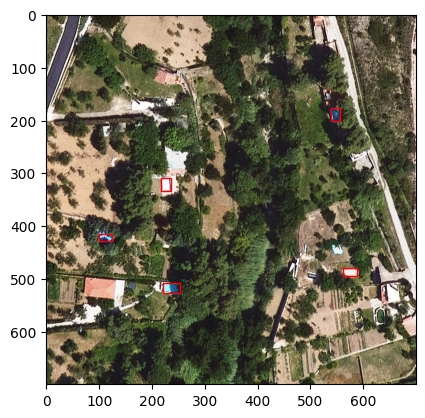

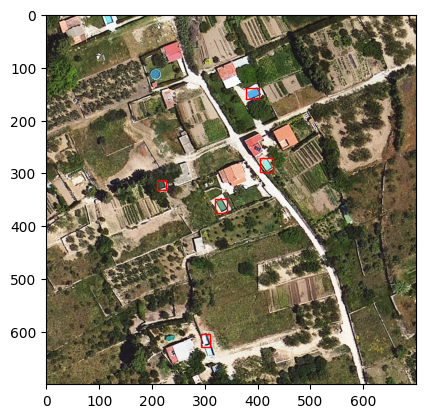

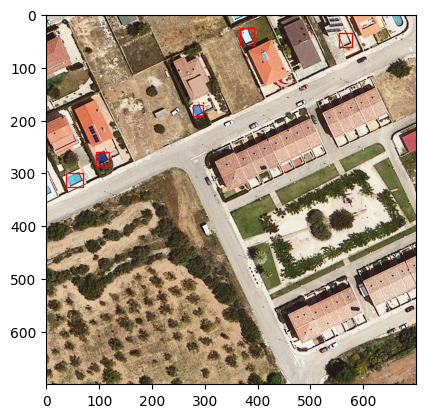

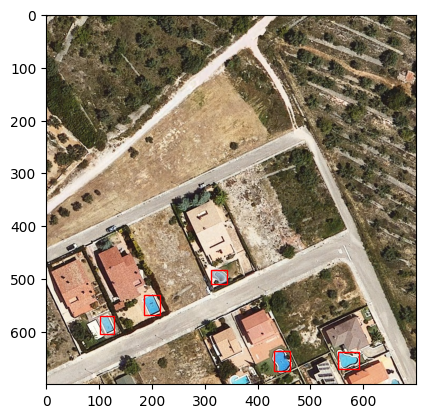

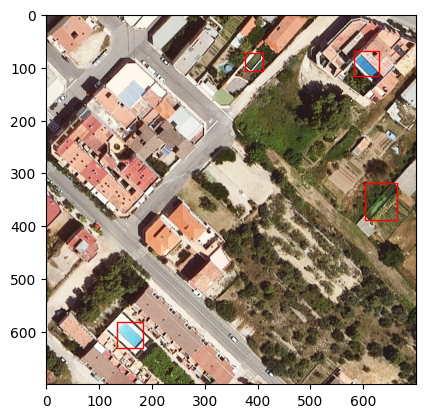

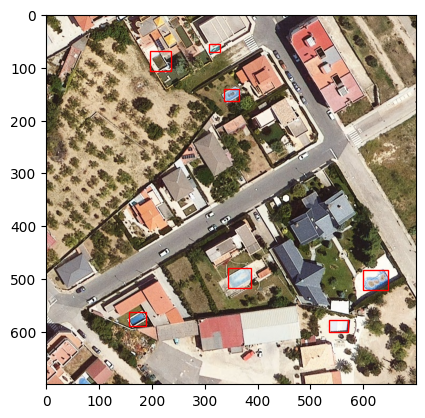

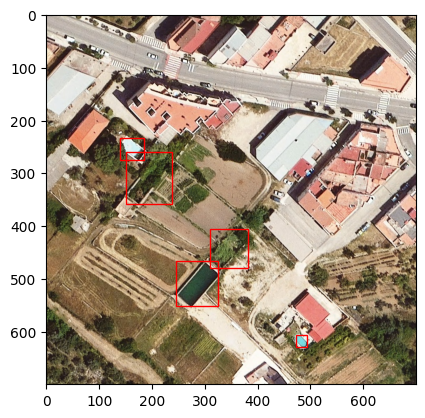

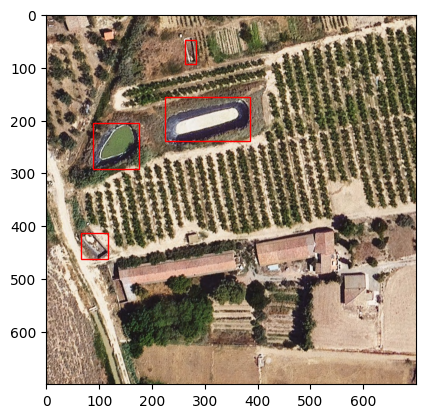

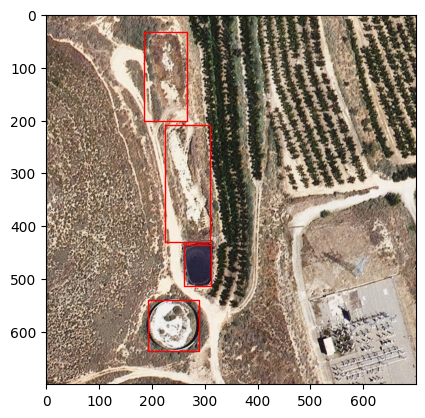

In [19]:
# Load annotations
with open(f'{path_annotations}annotations_4.json', 'r') as f:
    annotations = json.load(f)

# Show image with annotations drawn
for image_annotations in annotations["images"][:10]:
    fig, ax = plt.subplots()
    # Load image
    image_path = os.path.join(path_images, image_annotations["file_name"])
    image = Image.open(image_path).convert('RGB')

    for annotation in annotations["annotations"]:
        if annotation["image_id"] == image_annotations["id"]:
            x, y, w, h = annotation["bbox"]
            # Dibuja los rectángulos
            bb = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(bb)
    # Muestra la imagen
    ax.imshow(image)
    plt.show()
